In [17]:
import random
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("imagenet-sample")

Dataset already downloaded
Loading existing dataset 'imagenet-sample'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [18]:
# Get the ImageNet classes list
classes = dataset.default_classes


# Artificially corrupt 10% of the labels
num_mistakes = int(0.1 * len(dataset))
samples_to_corrupt = dataset.take(num_mistakes)

for sample in samples_to_corrupt:
    
    mistake_class = random.randint(0, 999)
    
    # Make sure it gets corrupted
    while classes[mistake_class] == sample.ground_truth.label:
        mistake_class = random.randint(0, 999)

    # Tag and corrupt the sample
    sample.tags.append("mistake")
    sample.ground_truth.label = classes[mistake_class]
    sample.save()

In [19]:
# Count the number of samples with the `mistake` tag
num_mistakes = len(dataset.match_tags("mistake"))
print("%d ground truth labels are now mistakes" % num_mistakes)

100 ground truth labels are now mistakes


/home/dan/anaconda3/envs/dev/lib/python3.9/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


 100% |███████████████| 1000/1000 [28.4s elapsed, 0s remaining, 34.4 samples/s]      



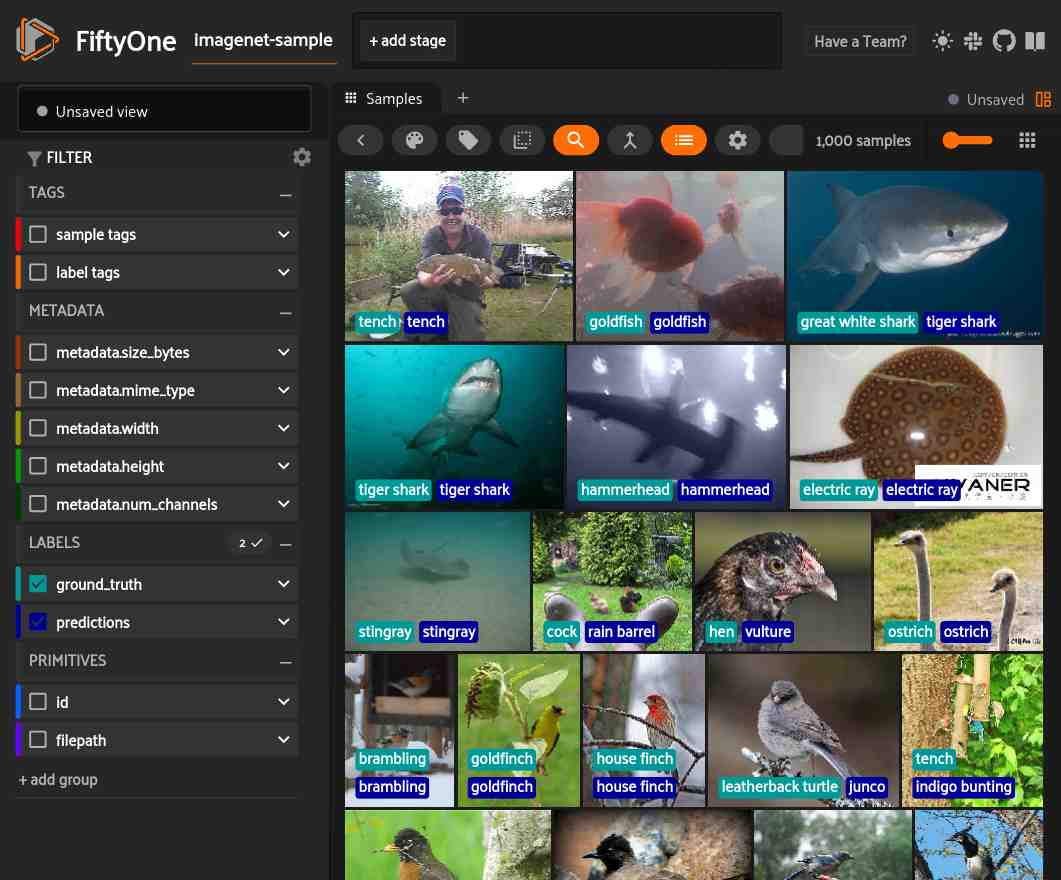

In [21]:
model = foz.load_zoo_model("mobilenet-v2-imagenet-torch")

dataset.apply_model(model, label_field="predictions")

session = fo.launch_app(dataset)

In [15]:
print(dataset)

Name:        cifar10-test
Media type:  image
Num samples: 10000
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)


In [24]:
import fiftyone.brain as fob

fob.compute_mistakenness(dataset, "predictions", label_field="ground_truth")

Computing mistakenness...
 100% |███████████████| 1000/1000 [692.6ms elapsed, 0s remaining, 1.4K samples/s]      
Mistakenness computation complete


In [27]:
# Sort by likelihood of mistake (most likely first)
mistake_view = (dataset
    .sort_by("mistakenness", reverse=True)
)

# Print some information about the view
print(mistake_view)

Dataset:     imagenet-sample
Media type:  image
Num samples: 1000
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    predictions:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    mistakenness: fiftyone.core.fields.FloatField
View stages:
    1. SortBy(field_or_expr='mistakenness', reverse=True, create_index=True)



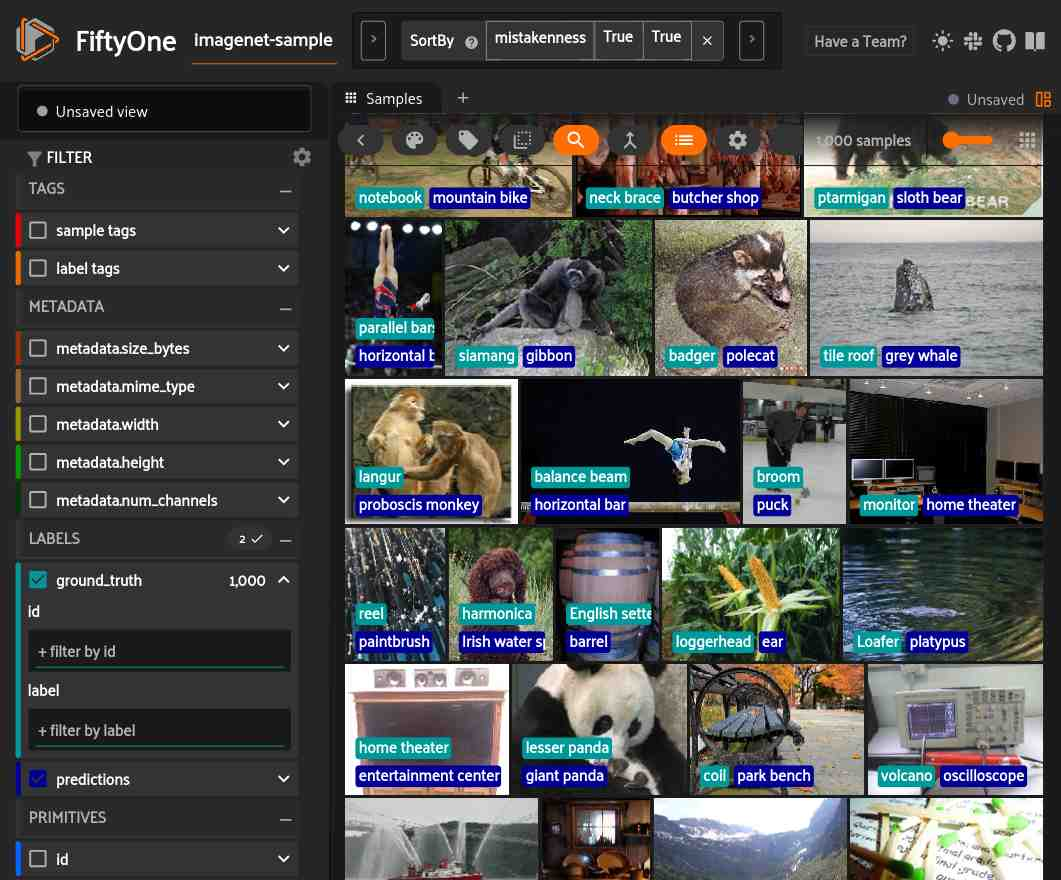

In [29]:
session.view = mistake_view